<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/cluster_yolo_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2

!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.9/618.9 kB 6.7 MB/s eta 0:00:00


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
path_to_best_cat_detector = '/content/gdrive/My Drive/Cat images/feral-cat-census.v1i.yolov8/runs/detect/train/weights/best.pt'
path_to_images = '/content/gdrive/My Drive/Cat images/original_images/'
path_to_cropped_images = '/content/runs/detect/cropped_images_2'

In [4]:
cat_detector_model = YOLO(path_to_best_cat_detector)  # load the cat detector model

In [25]:
# Run the YOLOv8 model and get a YOLO Results object
# https://docs.ultralytics.com/modes/predict/#working-with-results
# results = cat_detector_model.predict(source=path_to_image)


image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/IMG_0507.jpeg: 480x640 1 cat, 22.6ms
Speed: 8.9ms preprocess, 22.6ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2


In [26]:
# Extract the image sub areas and save them
# for r in results:
#  r.save_crop(save_dir='./runs/detect/cropped_images')


In [5]:
# Parameters for featire clustering model
INPUT_SHAPE = (224,224, 3) ## Pixel size of images accepted by VGG, in each of 3 channels
IMG_SIZE = INPUT_SHAPE[:2]

In [6]:
# load VGG model for image clustering
image_cluster_model = VGG16()
# remove the output layer
image_cluster_model = Model(inputs=image_cluster_model.inputs, outputs=image_cluster_model.layers[-2].output)

553467096/553467096 [==============================] - 5s 0us/step


In [7]:
def extract_features(file, model, img_size=IMG_SIZE):
    # load the image as a 224x224 array
    img = load_img(file, target_size=img_size)
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = np.expand_dims(img, axis=0)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [8]:
# from https://github.com/arvkevi/kneed/blob/main/kneed/knee_locator.py
# Implementation of Kneedle algorithm at repo https://github.com/arvkevi/kneed
import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
from typing import Tuple, Optional, Iterable

VALID_CURVE = ["convex", "concave"]
VALID_DIRECTION = ["increasing", "decreasing"]

try:
    import matplotlib.pyplot as plt
except ImportError:
    _has_matplotlib = False
    _matplotlib_not_found_err = ModuleNotFoundError(
        "This function needs Matplotlib to be executed. Please run command `pip install kneed[plot]` "
    )
else:
    _has_matplotlib = True


class KneeLocator(object):
    """
    Once instantiated, this class attempts to find the point of maximum
    curvature on a line. The knee is accessible via the `.knee` attribute.

    :param x: x values, must be the same length as y.
    :type x: 1D array of shape (`number_of_y_values`,) or list
    :param y: y values, must be the same length as x.
    :type y: 1D array of shape (`number_of_y_values`,) or list
    :param S: Sensitivity, the number of minimum number of data points below the local distance maximum before calling a knee. The original paper suggests default of 1.0
    :type S: float
    :param curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :type curve: str
    :param direction: one of {"increasing", "decreasing"}
    :type direction: str
    :param interp_method: one of {"interp1d", "polynomial"}
    :type interp_method: str
    :param online: kneed will correct old knee points if True, will return first knee if False
    :type online: bool
    :param polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :type polynomial_degree: int
    :ivar x: x values.
    :vartype x: array-like
    :ivar y: y values.
    :vartype y: array-like
    :ivar S: Sensitivity, original paper suggests default of 1.0
    :vartype S: integer
    :ivar curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :vartype curve: str
    :ivar direction: one of {"increasing", "decreasing"}
    :vartype direction: str
    :ivar interp_method: one of {"interp1d", "polynomial"}
    :vartype interp_method: str
    :ivar online: kneed will correct old knee points if True, will return first knee if False
    :vartype online: str
    :ivar polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :vartype polynomial_degree: int
    :ivar N: The number of `x` values in the
    :vartype N: integer
    :ivar all_knees: A set containing all the x values of the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: A set containing all the normalized x values of the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_knees_y: A list containing all the y values of the identified knee points.
    :vartype all_knees_y: list
    :ivar all_norm_knees_y: A list containing all the normalized y values of the identified knee points.
    :vartype all_norm_knees_y: list
    :ivar Ds_y: The y values from the fitted spline.
    :vartype Ds_y: numpy array
    :ivar x_normalized: The normalized x values.
    :vartype x_normalized: numpy array
    :ivar y_normalized: The normalized y values.
    :vartype y_normalized: numpy array
    :ivar x_difference: The x values of the difference curve.
    :vartype x_difference: numpy array
    :ivar y_difference: The y values of the difference curve.
    :vartype y_difference: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_maxima: The x values from the difference curve where the local maxima are located.
    :vartype x_difference_maxima: numpy array
    :ivar y_difference_maxima: The y values from the difference curve where the local maxima are located.
    :vartype y_difference_maxima: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype minima_indices: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_minima: The x values from the difference curve where the local minima are located.
    :vartype x_difference_minima: numpy array
    :ivar y_difference_minima: The y values from the difference curve where the local minima are located.
    :vartype y_difference_minima: numpy array
    :ivar Tmx: The y values that correspond to the thresholds on the difference curve for determining the knee point.
    :vartype Tmx: numpy array
    :ivar knee: The x value of the knee point. None if no knee/elbow was detected.
    :vartype knee: float
    :ivar knee_y: The y value of the knee point. None if no knee/elbow was detected
    :vartype knee_y: float
    :ivar norm_knee: The normalized x value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_knee_y: The normalized y value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee_y: float
    :ivar all_knees: The x values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_knees_y: The y values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: The normalized x values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_norm_knees_y: The normalized y values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar elbow: The x value of the elbow point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow: float
    :ivar elbow_y: The y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow_y: float
    :ivar norm_elbow: The normalized x value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_elbow_y: The normalized y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_elbow_y: float
    :ivar all_elbows: The x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_elbows_y: The y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_norm_elbows: The normalized x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    :ivar all_norm_elbows_y: The normalized y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    """

    def __init__(
        self,
        x: Iterable[float],
        y: Iterable[float],
        S: float = 1.0,
        curve: str = "concave",
        direction: str = "increasing",
        interp_method: str = "interp1d",
        online: bool = False,
        polynomial_degree: int = 7,
    ):
        # Step 0: Raw Input
        self.x = np.array(x)
        self.y = np.array(y)
        self.curve = curve
        self.direction = direction
        self.N = len(self.x)
        self.S = S
        self.all_knees = set()
        self.all_norm_knees = set()
        self.all_knees_y = []
        self.all_norm_knees_y = []
        self.online = online
        self.polynomial_degree = polynomial_degree

        # I'm implementing Look Before You Leap (LBYL) validation for direction
        # and curve arguments. This is not preferred in Python. The motivation
        # is that the logic inside the conditional once y_difference[j] is less
        # than threshold in find_knee() could have been evaluated improperly if
        # they weren't one of convex, concave, increasing, or decreasing,
        # respectively.
        valid_curve = self.curve in VALID_CURVE
        valid_direction = self.direction in VALID_DIRECTION
        if not all((valid_curve, valid_direction)):
            raise ValueError(
                "Please check that the curve and direction arguments are valid."
            )

        # Step 1: fit a smooth line
        if interp_method == "interp1d":
            uspline = interpolate.interp1d(self.x, self.y)
            self.Ds_y = uspline(self.x)
        elif interp_method == "polynomial":
            p = np.poly1d(np.polyfit(x, y, self.polynomial_degree))
            self.Ds_y = p(x)
        else:
            raise ValueError(
                "{} is an invalid interp_method parameter, use either 'interp1d' or 'polynomial'".format(
                    interp_method
                )
            )

        # Step 2: normalize values
        self.x_normalized = self.__normalize(self.x)
        self.y_normalized = self.__normalize(self.Ds_y)

        # Step 3: Calculate the Difference curve
        self.y_normalized = self.transform_y(
            self.y_normalized, self.direction, self.curve
        )
        # normalized difference curve
        self.y_difference = self.y_normalized - self.x_normalized
        self.x_difference = self.x_normalized.copy()

        # Step 4: Identify local maxima/minima
        # local maxima
        self.maxima_indices = argrelextrema(self.y_difference, np.greater_equal)[0]
        self.x_difference_maxima = self.x_difference[self.maxima_indices]
        self.y_difference_maxima = self.y_difference[self.maxima_indices]

        # local minima
        self.minima_indices = argrelextrema(self.y_difference, np.less_equal)[0]
        self.x_difference_minima = self.x_difference[self.minima_indices]
        self.y_difference_minima = self.y_difference[self.minima_indices]

        # Step 5: Calculate thresholds
        self.Tmx = self.y_difference_maxima - (
            self.S * np.abs(np.diff(self.x_normalized).mean())
        )

        # Step 6: find knee
        self.knee, self.norm_knee = self.find_knee()

        # Step 7: If we have a knee, extract data about it
        self.knee_y = self.norm_knee_y = None
        if self.knee:
            self.knee_y = self.y[self.x == self.knee][0]
            self.norm_knee_y = self.y_normalized[self.x_normalized == self.norm_knee][0]

    @staticmethod
    def __normalize(a: Iterable[float]) -> Iterable[float]:
        """normalize an array
        :param a: The array to normalize
        """
        return (a - min(a)) / (max(a) - min(a))

    @staticmethod
    def transform_y(y: Iterable[float], direction: str, curve: str) -> float:
        """transform y to concave, increasing based on given direction and curve"""
        # convert elbows to knees
        if direction == "decreasing":
            if curve == "concave":
                y = np.flip(y)
            elif curve == "convex":
                y = y.max() - y
        elif direction == "increasing" and curve == "convex":
            y = np.flip(y.max() - y)

        return y

    def find_knee(
        self,
    ):
        """This function is called when KneeLocator is instantiated. It identifies the knee value and sets the instance attributes."""
        if not self.maxima_indices.size:
            # No local maxima found in the difference curve
            # The line is probably not polynomial, try plotting
            # the difference curve with plt.plot(knee.x_difference, knee.y_difference)
            # Also check that you aren't mistakenly setting the curve argument
            return None, None
        # placeholder for which threshold region i is located in.
        maxima_threshold_index = 0
        minima_threshold_index = 0
        traversed_maxima = False
        # traverse the difference curve
        for i, x in enumerate(self.x_difference):
            # skip points on the curve before the the first local maxima
            if i < self.maxima_indices[0]:
                continue

            j = i + 1

            # reached the end of the curve
            if i == (len(self.x_difference) - 1):
                break

            # if we're at a local max, increment the maxima threshold index and continue
            if (self.maxima_indices == i).any():
                threshold = self.Tmx[maxima_threshold_index]
                threshold_index = i
                maxima_threshold_index += 1
            # values in difference curve are at or after a local minimum
            if (self.minima_indices == i).any():
                threshold = 0.0
                minima_threshold_index += 1

            if self.y_difference[j] < threshold:
                if self.curve == "convex":
                    if self.direction == "decreasing":
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]

                elif self.curve == "concave":
                    if self.direction == "decreasing":
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]

                # add the y value at the knee
                y_at_knee = self.y[self.x == knee][0]
                y_norm_at_knee = self.y_normalized[self.x_normalized == norm_knee][0]
                if knee not in self.all_knees:
                    self.all_knees_y.append(y_at_knee)
                    self.all_norm_knees_y.append(y_norm_at_knee)

                # now add the knee
                self.all_knees.add(knee)
                self.all_norm_knees.add(norm_knee)

                # if detecting in offline mode, return the first knee found
                if self.online is False:
                    return knee, norm_knee

        if self.all_knees == set():
            # No knee was found
            return None, None

        return knee, norm_knee

    def plot_knee_normalized(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Normalized Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """Plot the normalized curve, the difference curve (x_difference, y_normalized) and the knee, if it exists.

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Normalized Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x_normalized, self.y_normalized, "b", label="normalized curve")
        plt.plot(self.x_difference, self.y_difference, "r", label="difference curve")
        plt.xticks(
            np.arange(self.x_normalized.min(), self.x_normalized.max() + 0.1, 0.1)
        )
        plt.yticks(
            np.arange(self.y_difference.min(), self.y_normalized.max() + 0.1, 0.1)
        )

        plt.vlines(
            self.norm_knee,
            plt.ylim()[0],
            plt.ylim()[1],
            linestyles="--",
            label="knee/elbow",
        )
        plt.legend(loc="best")

    def plot_knee(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """
        Plot the curve and the knee, if it exists

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x, self.y, "b", label="data")
        plt.vlines(
            self.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow"
        )
        plt.legend(loc="best")

    # Niceties for users working with elbows rather than knees
    @property
    def elbow(self):
        return self.knee

    @property
    def norm_elbow(self):
        return self.norm_knee

    @property
    def elbow_y(self):
        return self.knee_y

    @property
    def norm_elbow_y(self):
        return self.norm_knee_y

    @property
    def all_elbows(self):
        return self.all_knees

    @property
    def all_norm_elbows(self):
        return self.all_norm_knees

    @property
    def all_elbows_y(self):
        return self.all_knees_y

    @property
    def all_norm_elbows_y(self):
        return self.all_norm_knees_y


image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/Places - 1 of 5.jpeg: 480x640 2 cats, 7.4ms
Speed: 4.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/Places - 2 of 5.jpeg: 480x640 2 cats, 6.8ms
Speed: 4.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/Places - 3 of 5.jpeg: 480x640 1 cat, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/Places - 4 of 5.jpeg: 480x640 3 cats, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/gdrive/My Drive/Cat images/original_images/nreading/Places - 5 of 5.jpeg: 480x640 2 cats, 11.4ms
Speed: 5.0ms preprocess, 11.4ms infe

1/1 [==============================] - 0s 20ms/step


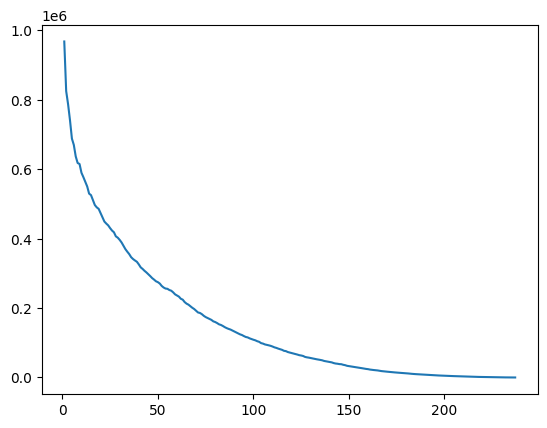

In [13]:
test_case_images = []

# Read the dataframe of the original images from a CSV file
df = pd.read_csv(path_to_images + 'image_index_with_gps_and_clusters.csv')
df['file_path'].apply(lambda fp: test_case_images.append(fp))

# Run the YOLOv8 model and get a YOLO Results object for
# each file named in the df
# https://docs.ultralytics.com/modes/predict/#working-with-results
for test_case in test_case_images:
  results = cat_detector_model.predict(source=os.path.join(path_to_images, test_case))
  # Extract the image sub areas and save them as files
  for r in results:
    r.save_crop(save_dir=path_to_cropped_images)

path_to_cropped_and_classified_images = os.path.join(path_to_cropped_images, 'cat')
# Compile a list of all the cropped images
cropped_image_files = []
with os.scandir(path_to_cropped_and_classified_images) as files:
  for file in files:
    cropped_image_files.append(file.name)

# Extract the features from each test case image
data = {}
for cropped_image_file in cropped_image_files:
  feature = extract_features(os.path.join(path_to_cropped_and_classified_images, cropped_image_file), image_cluster_model)
  data[cropped_image_file] = feature

# Get list of filenames
filenames = np.array(list(data.keys()))
# Get a list of just the features
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

x_values = []
y_values = []

pca = PCA(n_components = 100, random_state=22)
pca.fit(feat)

for i in range(len(filenames)):
  kmeans = KMeans(n_clusters=i+1, n_init='auto', random_state=22)
  x = pca.transform(feat)
  kmeans.fit(x)
  x = x_values.append(i+1)
  y = y_values.append(kmeans.inertia_)
plt.plot(x_values, y_values)


In [14]:
sensitivity = [1, 2, 4, 8, 16, 32, 64]
elbows = []
norm_elbows = []
for s in sensitivity:
  kn = KneeLocator(x_values, y_values, curve='convex', direction='decreasing', S=s)
  elbows.append(kn.elbow)
elbows

[53, 79, 79, 79, 79, 79, 79]